# HW4: Structure-from-motion

ref: 
https://blog.csdn.net/haizimin/article/details/49836077,
https://github.com/MasteringOpenCV/code/tree/master/Chapter4_StructureFromMotion

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3

## 讀取圖片

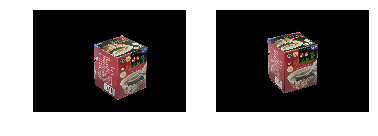

In [56]:
image1 = cv2.imread('./data/Mesona1.JPG')
image2 = cv2.imread('./data/Mesona2.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

## 計算相機內部參數

In [57]:
intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                              [0, 1.4219, 0.3802],
                              [0, 0, 0.0010]])
intrinsic_matrix_inverse1 = np.linalg.inv(intrinsic_matrix1)
print(intrinsic_matrix1)
print(np.transpose(intrinsic_matrix1))

[[  1.42190000e+00   5.00000000e-03   5.09200000e-01]
 [  0.00000000e+00   1.42190000e+00   3.80200000e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e-03]]
[[  1.42190000e+00   0.00000000e+00   0.00000000e+00]
 [  5.00000000e-03   1.42190000e+00   0.00000000e+00]
 [  5.09200000e-01   3.80200000e-01   1.00000000e-03]]


## 計算特徵點

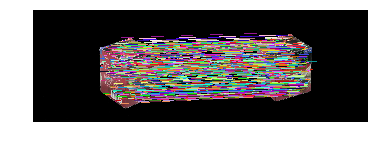

(<matplotlib.image.AxesImage at 0x1ea28757b38>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [58]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## 計算Fundamental和Essential矩陣

In [59]:
# fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamental_matrix, _status = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, 1., 0.99, None)
print("F\n", fundamental_matrix)

# essential matrix (ref: Multiple View Geometry 9.12)
essential_matrix = np.transpose(intrinsic_matrix1) * fundamental_matrix * intrinsic_matrix1
print("E\n", essential_matrix)

# first camera matrix (ref: Multiple View Geometry 9.19)
camera_matrix1 = np.array([[1,0,0,0],
                           [0,1,0,0],
                           [0,0,1,0]])

def check_coherent_rotatio(rotation):
    if(abs(np.linalg.det(rotation))-1.0 > 1e-07):
        return False
    return True
_u, _s, _vt = np.linalg.svd(essential_matrix)
print("u\n", _u, "\ns\n", _s, "\nvh\n", _vh)

# skew-symmetric (ref: Multiple View Geometry 9.13)
w = np.array([[0, -1, 0], 
              [1, 0, 0], 
              [0, 0, 1]])

# 這裡有四種可能，需要點是否都在兩個相機前方(ref: Multiple View Geometry 9.14)
R2 = np.dot(np.dot(_u,w), _vt)
T2 = _u[:,2]
if(check_coherent_rotatio(R2) != True):
    camera_matrix2 = 0
else:
    camera_matrix2 = np.array([[R2[0,0], R2[0,1], R2[0,2], T2[0]],
                           [R2[1,0], R2[1,1], R2[1,2], T2[1]],
                           [R2[2,0], R2[2,1], R2[2,2], T2[2]]])
print("R2\n", R2)
print("T2\n", T2)
print("camera matrix2\n", camera_matrix2)

F
 [[  1.30170502e-07  -3.74285972e-07  -1.35177595e-03]
 [ -2.20353024e-06  -6.57283249e-08   2.48823660e-02]
 [  5.31704934e-04  -2.24088850e-02   1.00000000e+00]]
E
 [[  2.63178670e-07  -0.00000000e+00  -0.00000000e+00]
 [ -0.00000000e+00  -1.32889502e-07   0.00000000e+00]
 [  0.00000000e+00  -0.00000000e+00   1.00000000e-06]]
u
 [[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]] 
s
 [  1.00000000e-06   2.63178670e-07   1.32889502e-07] 
vh
 [[ 0.  0.  1.]
 [ 1.  0.  0.]
 [-0. -1. -0.]]
R2
 [[ 0.  0.  1.]
 [ 0. -1.  0.]
 [-1.  0.  0.]]
T2
 [ 0.  1.  0.]
camera matrix2
 [[ 0.  0.  1.  0.]
 [ 0. -1.  0.  1.]
 [-1.  0.  0.  0.]]


## 將像素對應到三維空間

(800, 1200, 3)


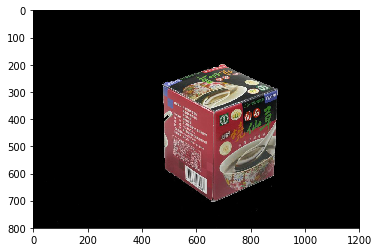

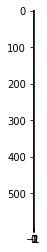

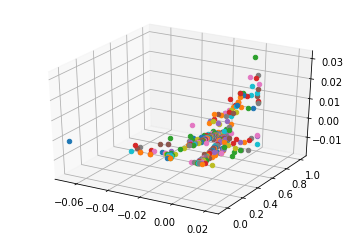

In [66]:
def linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2):
    A = np.array([[(x1[0]*camera_matrix1[2,0]-camera_matrix1[0,0]), (x1[0]*camera_matrix1[2,1]-camera_matrix1[0,1]), (x1[0]*camera_matrix1[2,2]-camera_matrix1[0,2])],
                  [(x1[1]*camera_matrix1[2,0]-camera_matrix1[1,0]), (x1[1]*camera_matrix1[2,1]-camera_matrix1[1,1]), (x1[1]*camera_matrix1[2,2]-camera_matrix1[1,2])],
                  [(x2[0]*camera_matrix2[2,0]-camera_matrix2[0,0]), (x2[0]*camera_matrix2[2,1]-camera_matrix2[0,1]), (x2[0]*camera_matrix2[2,2]-camera_matrix2[0,2])],
                  [(x2[1]*camera_matrix2[2,0]-camera_matrix2[1,0]), (x2[1]*camera_matrix2[2,1]-camera_matrix2[1,1]), (x2[1]*camera_matrix2[2,2]-camera_matrix2[1,2])]])
    
    B = np.array([-(x1[0]*camera_matrix1[2,3]-camera_matrix1[0,3]),
                -(x1[1]*camera_matrix1[2,3]-camera_matrix1[1,3]),
                -(x2[0]*camera_matrix2[2,3]-camera_matrix2[0,3]),
                -(x2[1]*camera_matrix2[2,3]-camera_matrix2[1,3])])
    
    retbal, dst = cv2.solve(A,B, flags=cv2.DECOMP_SVD)
    return retbal, dst

def triangulate_points(keypt1, keypt2, camera_matrix1, camera_matrix2):
    
    points = np.zeros((len(keypt1), 3))
    reproject_errors = np.zeros(len(keypt1))
    for i in range(len(keypt1)):
    
        # convert to normalized homogeneous coordinates
        kp1 = keypt1[i]
        x1 = np.array([kp1[0], kp1[1], 1])
        x1m = np.dot(intrinsic_matrix_inverse1, x1)
        x1 = x1m
        
        # convert to normalized homogeneous coordinates
        kp2 = keypt2[i]
        x2 = np.array([kp2[0], kp2[1], 1])
        x2m = np.dot(intrinsic_matrix_inverse1, x2)
        x2 = x2m

        # triangulate
        state, X = linear_LS_Triangulation(x1, camera_matrix1, x2, camera_matrix2)
        points[i] = X[:,0]
        
        # calculate reprojection error
        #reproject_pt = np.dot(intrinsic_matrix1, camera_matrix2)
        #reproject_pt = np.dot(reproject_pt, X)
        #reproject_pt = ((reproject_pt[0]/reproject_pt[2]), (reproject_pt[1]/reproject_pt[2]))
        #reproject_errors[i] = reproject_pt
    #error = np.mean(reproject_errors)
    #print("error:", error)
    return points

three_points = triangulate_points(imgpts1, imgpts2, camera_matrix1, camera_matrix2)
print(image1.shape)

plt.imshow(image1), plt.show()
plt.imshow(imgpts1), plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, p in enumerate(three_points):
    xs = three_points[i][0]
    ys = three_points[i][1]
    zs = three_points[i][2]
    ax.scatter(xs, ys, zs)
plt.show()